# Multi-armed Bandits

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from matplotlib import pyplot as plt

A `bandit` is a slot machine with *n* arms. When an arm is *pulled* a random reward is drawn from a normal distribution with different mean *m* and variance = `1`

Pulling an arm does not change the state of the system yet. We'll consider bandits with state later.

In [2]:
# Initialize the random pool
seed = 65432874
rand = np.random.RandomState(seed)

def pull_bandit(bandits, bandit):
    return rand.normal(bandits[bandit], 1)   # choose from normal dist, with mean from bandit
                                             # and sigma = 1 (thus variance=1)

## Action-value Methods

$\epsilon$-greedy choose

In [3]:
def act_v_reward(q_a, n_a, action):
    '''Computes previous rewards for each action using Action Value Reward'''
    return q_a[action] / n_a[action]

def choose_e_greedy(q_t, eps):
    '''eps-greedy choose'''
    if rand.random_sample() > eps:
        # choose most rewarding actions
        max_qs = np.argwhere(q_t == np.amax(q_t)).flatten()
        return np.random.choice(max_qs, 1)[0]
    
    return np.random.choice(n, 1)[0]

## n-armed TestBed

In [4]:
def init_bandits(num_bandits):
    return np.array([rand.normal(0, 1) for i in range(num_bandits)])

Now, for a number of steps, we decide on our next action using our current state, Then, we perform the action and get a numerical reward from the environment. Using the reward, we update our state w.r.t the action we just did. 

`run` function expects the `next_action` function and which is run on each iteration. We can provide different ways of choosing our next action without changing the `run` function now.

In [5]:
n = 10
def run(num_steps, num_runs, next_action):
    q_sr = np.zeros((num_steps, num_runs))        # reward gained in each step per run
    for run in range(num_runs):
        bandits = init_bandits(n)
        
        q_a = np.zeros(n)     # total reward of doing a specific action: Q(a)
        n_a = np.zeros(n)     # number of times (action) a chosen 
        q_t = np.zeros(n)     # expected reward from next action
        for step in range(num_steps):
            action = next_action(q_t)
            reward = pull_bandit(bandits, action)
            # learn from the state, reward, action 
            q_a[action] += reward
            n_a[action] += 1
            q_t[action] = act_v_reward(q_a, n_a, action)
            
            q_sr[step][run] = reward
    q_s = np.average(q_sr, axis=1) 
    return q_s

Put it all together and run for $\epsilon$ = 0.1 and $\epsilon$ = 0.01 

In [6]:
num_steps = 1000
num_runs = 100

eg_e1 = run(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.1))

rand = np.random.RandomState(seed)     # re-initialize the RNG

eg_e2 = run(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.01))

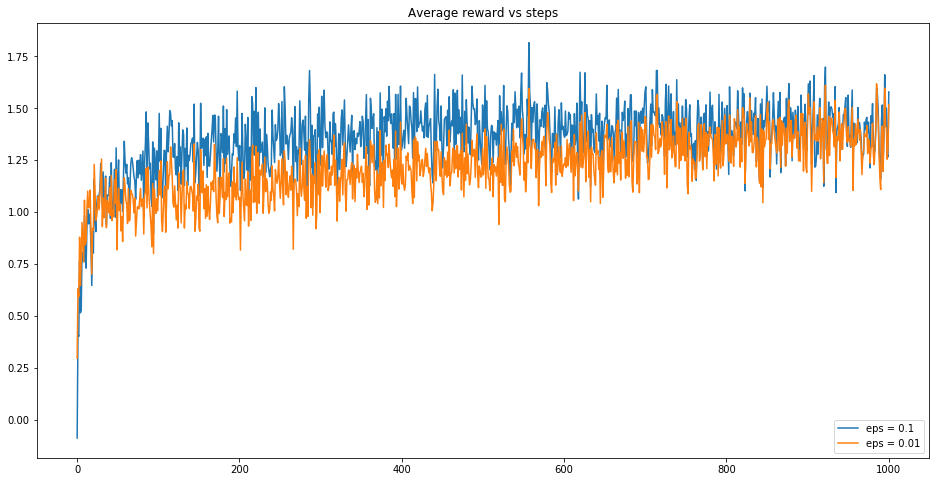

In [7]:
x = np.linspace(0, num_steps, num=num_steps)
plt.figure(figsize=(16, 8))
plt.plot(x, eg_e1, label='eps = 0.1')
plt.plot(x, eg_e2, label='eps = 0.01')
plt.title('Average reward vs steps')
plt.legend(loc='lower right')
plt.show()

## Softmax Action Selection

In [8]:
def choose_softmax(q_t, temp):
    '''softmax choose'''
    # calculate weights of each action
    weight_qt = np.exp(q_t / temp)
    total_w = np.sum(weight_qt)
    p_qt = weight_qt / total_w
    # choose from actions with weights
    return np.random.choice(n, 1, p=p_qt)[0]

In [9]:
rand = np.random.RandomState(seed)     # re-initialize the RNG

sm_e1 = run(num_steps, num_runs, lambda x: choose_softmax(x, 0.5))

rand = np.random.RandomState(seed)     # re-initialize the RNG

sm_e2 = run(num_steps, num_runs, lambda x: choose_softmax(x, 0.01))

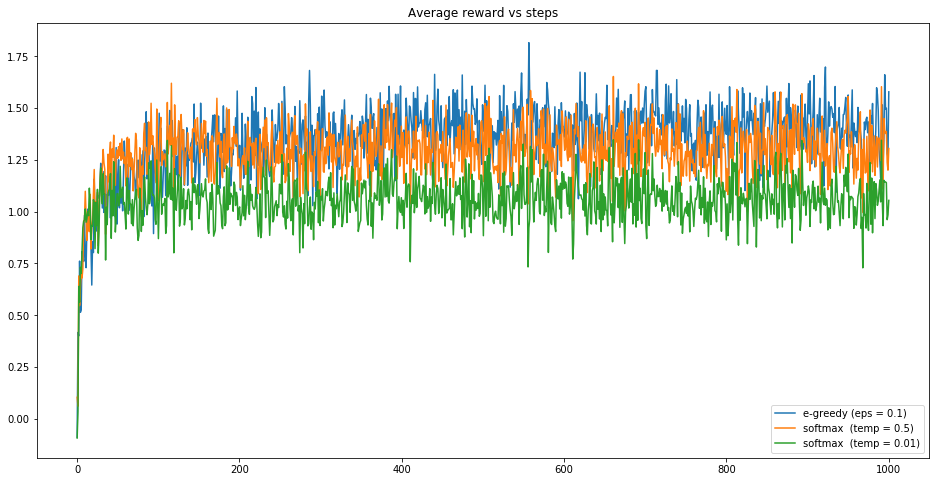

In [10]:
x = np.linspace(0, num_steps, num=num_steps)
plt.figure(figsize=(16, 8))
plt.plot(x, eg_e1, label='e-greedy (eps = 0.1)')
plt.plot(x, sm_e1, label='softmax  (temp = 0.5)')
plt.plot(x, sm_e2, label='softmax  (temp = 0.01)')
plt.title('Average reward vs steps')
plt.legend(loc='lower right')
plt.show()

## Incremental Implementation

In [11]:
def run_incremental(num_steps, num_runs, next_action):
    q_sr = np.zeros((num_steps, num_runs))        # reward gained in each step per run
    for run in range(num_runs):
        bandits = init_bandits(n)
        
        q_t = np.zeros(n)     # expected reward from next action
        n_a = np.zeros(n)     # number of times (action) a chosen 
        for step in range(num_steps):
            action = next_action(q_t)
            reward = pull_bandit(bandits, action)
            # learn incrementally
            n_a[action] += 1
            q_t[action] += (reward - q_t[action]) / n_a[action]
            
            q_sr[step][run] = reward
    q_s = np.average(q_sr, axis=1) 
    return q_s

In [12]:
rand = np.random.RandomState(seed)     # re-initialize the RNG

eg_e3 = run_incremental(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.1))

rand = np.random.RandomState(seed)     # re-initialize the RNG

eg_e4 = run_incremental(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.01))

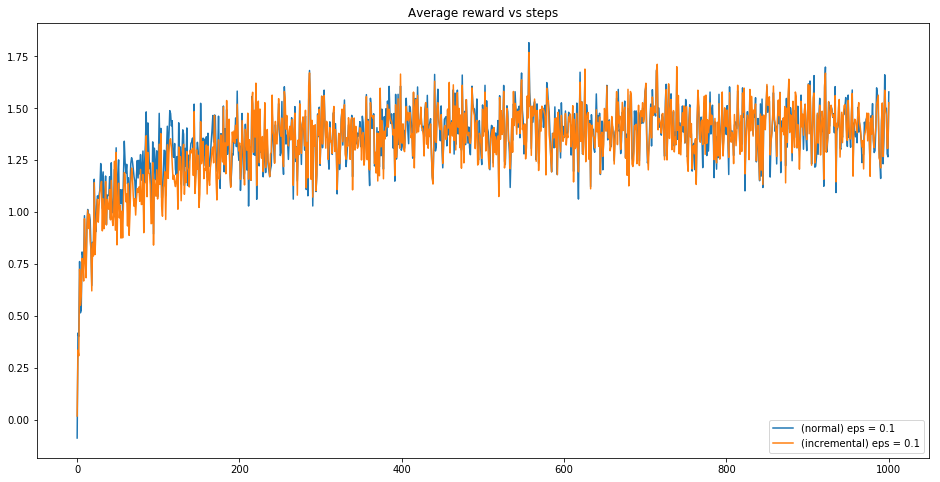

In [13]:
x = np.linspace(0, num_steps, num=num_steps)
plt.figure(figsize=(16, 8))
plt.plot(x, eg_e1, label='(normal) eps = 0.1')
plt.plot(x, eg_e3, label='(incremental) eps = 0.1')
plt.title('Average reward vs steps')
plt.legend(loc='lower right')
plt.show()

## Tracking a Nonstationary Problem

In [18]:
def run_nonstationary(num_steps, num_runs, next_action, alpha=None):
    q_sr = np.zeros((num_steps, num_runs))        # reward gained in each step per run
    for run in range(num_runs):
        bandits = np.zeros(n)
        
        q_t = np.zeros(n)     # expected reward from next action
        n_a = np.zeros(n)     # number of times (action) a chosen 
        for step in range(num_steps):          
            action = next_action(q_t)
            reward = pull_bandit(bandits, action)
            # learn incrementally
            n_a[action] += 1
            # use a cl
            step_size = alpha if alpha else n_a[action]
            q_t[action] += (reward - q_t[action]) / step_size
            
            # bandits walk randomly
            bandits = bandits + rand.normal(0, 0.01, n)
            
            q_sr[step][run] = reward
    q_s = np.average(q_sr, axis=1) 
    return q_s

In [20]:
num_steps = 2000

rand = np.random.RandomState(seed)     # re-initialize the RNG

eg_e5 = run_nonstationary(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.1), alpha=0.1)

rand = np.random.RandomState(seed)     # re-initialize the RNG

eg_e6 = run_nonstationary(num_steps, num_runs, lambda x: choose_e_greedy(x, 0.1))

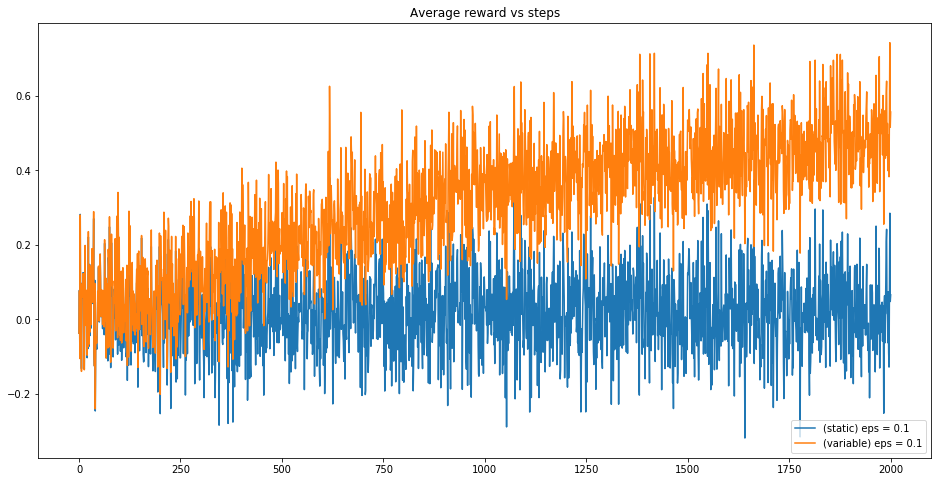

In [21]:
x = np.linspace(0, num_steps, num=num_steps)
plt.figure(figsize=(16, 8))
plt.plot(x, eg_e5, label='(static) eps = 0.1')
plt.plot(x, eg_e6, label='(variable) eps = 0.1')
plt.title('Average reward vs steps')
plt.legend(loc='lower right')
plt.show()